This notebook shows:
- Install SystemML Python package and jar file
  - pip
  - SystemML 'Hello World'
- Example 1: Matrix Multiplication
- Load diabetes dataset from scikit-learn
- Example 2: Implement three different algorithms to train linear regression model
  - Algorithm 1: Linear Regression - Direct Solve (no regularization)
  - Algorithm 2: Linear Regression - Batch Gradient Descent (no regularization)
  - Algorithm 3: Linear Regression - Conjugate Gradient (no regularization)
- Example 3: Invoke existing SystemML algorithm script LinearRegDS.dml using MLContext API
- Example 4: Invoke existing SystemML algorithm using scikit-learn/SparkML pipeline like API
- Example 5: Invoking a Keras model with SystemML

# Install SystemML Python package and jar file

In [ ]:
#!pip install --upgrade systemml
!pip install --upgrade https://github.com/niketanpansare/future_of_data/raw/master/systemml-1.1.0-SNAPSHOT-python.tar.gz
!ln -s -f ~/.local/lib/python2.7/site-packages/systemml/systemml-java/*.jar ~/data/libs/

In [1]:
!pip show systemml

Name: systemml
Version: 1.1.0
Summary: Apache SystemML is a distributed and declarative machine learning platform.
Home-page: http://systemml.apache.org/
Author: Apache SystemML
Author-email: dev@systemml.apache.org
License: Apache 2.0
Location: /gpfs/global_fs01/sym_shared/YPProdSpark/user/scf4-b69284e1625908-5ca7710237a9/.local/lib/python2.7/site-packages
Requires: Pillow, scikit-learn, pandas, scipy, numpy


### Import SystemML API 

In [2]:
sc.version

u'2.1.0'

In [3]:
from systemml import MLContext, dml
# Create a MLContext object
ml = MLContext(sc)
# And print the information of SystemML version
print(ml.info())

Archiver-Version: Plexus Archiver
Artifact-Id: systemml
Build-Jdk: 1.8.0_111
Build-Time: 2017-12-19 13:17:52 CST
Built-By: biuser
Created-By: Apache Maven 3.0.5
Group-Id: org.apache.systemml
Main-Class: org.apache.sysml.api.DMLScript
Manifest-Version: 1.0
Minimum-Recommended-Spark-Version: 2.1.0
Version: 1.1.0-SNAPSHOT



In [4]:
# Create a DML script for a Hello World' example and execute it using MLContext
script = dml(""" 
print('Hello World'); 
""")
ml.execute(script)

Hello World
SystemML Statistics:
Total execution time:		0.001 sec.
Number of executed Spark inst:	0.




MLResults

In [5]:
# Let's modify the above script to get the Hello World string
script = dml(""" 
s = 'Hello World' 
""").output("s")

hello_world_str = ml.execute(script).get("s")

print(hello_world_str)

SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	0.


Hello World


### Import numpy, sklearn, and define some helper functions

In [6]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
plt.switch_backend('agg')

# Example 1: Matrix Multiplication

### SystemML script to generate a random matrix, perform matrix multiplication, and compute the sum of the output

In [7]:
script = """
    X = rand(rows=$nr, cols=1000, sparsity=0.5)
    A = t(X) %*% X
    s = sum(A)
"""
prog = dml(script).input('$nr', 1e6).output('s')
s = ml.execute(prog).get('s')
print s

[Stage 0:>                                                         (0 + 0) / 59]
[Stage 0:>                                                         (0 + 1) / 59]
[Stage 0:>                                                        (0 + 10) / 59]
[Stage 0:>                                                        (1 + 10) / 59]
[Stage 0:==========>                                             (11 + 10) / 59]
[Stage 0:=================>                                      (18 + 10) / 59]
[Stage 0:=======================>                                (25 + 10) / 59]
[Stage 0:================================>                       (34 + 10) / 59]
[Stage 0:=========================================>              (44 + 10) / 59]
[Stage 0:====================================================>    (54 + 5) / 59]
SystemML Statistics:
Total execution time:		14.134 sec.
Number of executed Spark inst:	2.

                                                                                

62608781691.5


# Load diabetes dataset from scikit-learn 

In [8]:
%matplotlib inline

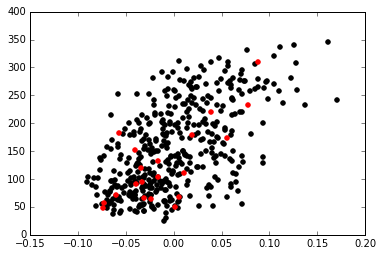

In [9]:
diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 2]
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]
diabetes_y_train = np.matrix(diabetes.target[:-20]).T
diabetes_y_test = np.matrix(diabetes.target[-20:]).T

plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

In [10]:
diabetes_y_train

matrix([[ 151.],
        [  75.],
        [ 141.],
        [ 206.],
        [ 135.],
        [  97.],
        [ 138.],
        [  63.],
        [ 110.],
        [ 310.],
        [ 101.],
        [  69.],
        [ 179.],
        [ 185.],
        [ 118.],
        [ 171.],
        [ 166.],
        [ 144.],
        [  97.],
        [ 168.],
        [  68.],
        [  49.],
        [  68.],
        [ 245.],
        [ 184.],
        [ 202.],
        [ 137.],
        [  85.],
        [ 131.],
        [ 283.],
        [ 129.],
        [  59.],
        [ 341.],
        [  87.],
        [  65.],
        [ 102.],
        [ 265.],
        [ 276.],
        [ 252.],
        [  90.],
        [ 100.],
        [  55.],
        [  61.],
        [  92.],
        [ 259.],
        [  53.],
        [ 190.],
        [ 142.],
        [  75.],
        [ 142.],
        [ 155.],
        [ 225.],
        [  59.],
        [ 104.],
        [ 182.],
        [ 128.],
        [  52.],
        [  37.],
        [ 170.

# Example 2: Implement three different algorithms to train linear regression model

## Algorithm 1: Linear Regression - Direct Solve (no regularization) 

#### Preliminaries

1. The builtin function `solve(A, b)` computes the least squares solution for system of linear equations 
$$ Ax = b $$
for the vector x such that $$ || \; Ax \; – \; b \;|| $$ is minimized. It is important to note that this function can operate only on small-to-medium sized input matrix that can fit in the driver memory. See the [DML language reference](http://apache.github.io/systemml/dml-language-reference.html) for more details.

2. Linear regression model assumes that relationship between input explanatory (feature) variables X and numerical response variable y is linear. The goal is to estimate regression coefficient w (and residual variable) such that 

$$ y = \text{Normal}(Xw, \sigma^2) $$

$$ 
\begin{align*}
\text{Cost function, } J(w) &= \dfrac{1}{2} (Xw - y)^2
\end{align*}$$

Differentiating with respect to w,

$$ 
\begin{align*}
dw &= \dfrac{\partial}{\partial w} \dfrac{1}{2} (Xw - y)^2 \\
&= \dfrac{1}{2} 2 X^T (Xw - y) \\
&= (X^TX)w - X^Ty 
\end{align*}$$


#### Setting the gradient
To find minima, we set the derivative with respect to w to zero, 
$$\begin{align*}
(X^T X)w - (X^T y) &= 0 \\ 
w &= (X^T X)^{-1}(X^T y) \\
\text{Let } \; A &= X^T X \\
\text{and } \; b &= X^T y \\
\text{Therefore,} \; w &= solve(A, b)
\end{align*}$$

In [12]:
script = """
    # add constant feature to X to model intercept
    ones = matrix(1, rows=nrow(X), cols=1)
    X = cbind(X, ones)
    A = t(X) %*% X
    b = t(X) %*% y
    w = solve(A, b)
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]
"""

In [13]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.028 sec.
Number of executed Spark inst:	2.




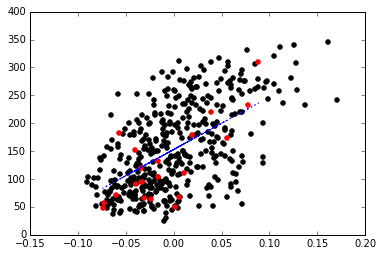

In [14]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='blue', linestyle ='dotted')

## Algorithm 2: Linear Regression - Batch Gradient Descent (no regularization)

#### Algorithm
`Step 1: Start with an initial point 
while(not converged) { 
  Step 2: Compute gradient dw. 
  Step 3: Compute stepsize alpha.     
  Step 4: Update: w_new = w_old - alpha*dw 
}`

![Gradient Descent](http://blog.datumbox.com/wp-content/uploads/2013/10/gradient-descent.png)

#### Gradient formula

$$ dw = r = (X^T X)w - (X^T y) $$

#### Step size formula

We perform a line search to choose the step size `alpha` to minimize the cost function J(w). From basic calculus, `alpha` minimizes the function J(w) when the directional derivative with respect to `alpha` is zero. 

$$ alpha = \dfrac{r^T r}{ r^T X^T X r } $$

In [15]:
script = """
    # add constant feature to X to model intercepts
    ones = matrix(1, rows=nrow(X), cols=1)
    X = cbind(X, ones)
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = (t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w - dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

In [16]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w').output('bias')
w, bias = ml.execute(prog).get('w', 'bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.081 sec.
Number of executed Spark inst:	2.




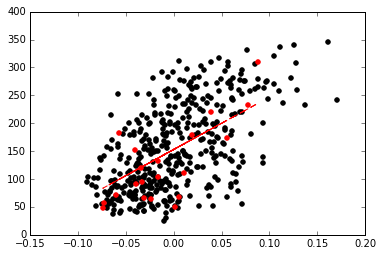

In [17]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Algorithm 3: Linear Regression - Conjugate Gradient (no regularization)

Problem with gradient descent: Takes very similar directions many times

Solution: Enforce conjugacy

`Step 1: Start with an initial point 
while(not converged) {
   Step 2: Compute gradient dw.
   Step 3: Compute stepsize alpha.
   Step 4: Compute next direction p by enforcing conjugacy with previous direction.
   Step 4: Update: w_new = w_old + alpha*p
}`

![Gradient Descent vs Conjugate Gradient](http://i.stack.imgur.com/zh1HH.png)


In [18]:
script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    m = ncol(X); i = 1; 
    max_iter = 20;
    w = matrix (0, rows = m, cols = 1); # initialize weights to 0
    dw = - t(X) %*% y; p = - dw;        # dw = (X'X)w - (X'y)
    norm_r2 = sum (dw ^ 2); 
    for(i in 1:max_iter) {
        q = t(X) %*% (X %*% p)
        alpha = norm_r2 / sum (p * q);  # Minimizes f(w - alpha*r)
        w = w + alpha * p;              # update weights
        dw = dw + alpha * q;           
        old_norm_r2 = norm_r2; norm_r2 = sum (dw ^ 2);
        p = -dw + (norm_r2 / old_norm_r2) * p; # next direction - conjugacy to previous direction
        i = i + 1;
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

In [19]:
prog = dml(script).input(X=diabetes_X_train, y=diabetes_y_train).output('w').output('bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

SystemML Statistics:
Total execution time:		0.007 sec.
Number of executed Spark inst:	2.




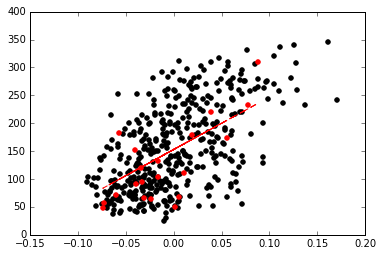

In [20]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Example 3: Invoke existing SystemML algorithm script LinearRegDS.dml using MLContext API

In [21]:
from systemml import dmlFromResource
prog = dmlFromResource('scripts/algorithms/LinearRegDS.dml').input(X=diabetes_X_train, y=diabetes_y_train).input('$icpt',1.0).output('beta_out')
w = ml.execute(prog).get('beta_out')
w = w.toNumPy()
bias=w[1]

BEGIN LINEAR REGRESSION SCRIPT
Reading X and Y...
Calling the Direct Solver...
Computing the statistics...
AVG_TOT_Y,153.36255924170615
STDEV_TOT_Y,77.21853383600028
AVG_RES_Y,3.633533705616816E-14
STDEV_RES_Y,63.038506337610244
DISPERSION,3973.853281276927
R2,0.3351312506863875
ADJUSTED_R2,0.33354822985468835
R2_NOBIAS,0.3351312506863875
ADJUSTED_R2_NOBIAS,0.33354822985468835
Writing the output matrix...
END LINEAR REGRESSION SCRIPT
SystemML Statistics:
Total execution time:		0.008 sec.
Number of executed Spark inst:	2.




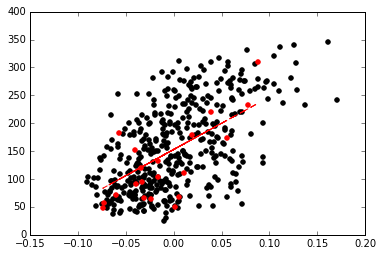

In [22]:
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, (w[0]*diabetes_X_test)+bias, color='red', linestyle ='dashed')

# Example 4: Invoke existing SystemML algorithm using scikit-learn/SparkML pipeline like API

*mllearn* API allows a Python programmer to invoke SystemML's algorithms using scikit-learn like API as well as Spark's MLPipeline API.

In [23]:
from pyspark.sql import SQLContext
from systemml.mllearn import LinearRegression
sqlCtx = SQLContext(sc)

In [24]:
regr = LinearRegression(sqlCtx)
# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

BEGIN LINEAR REGRESSION SCRIPT
Reading X and Y...
Running the CG algorithm...
||r|| initial value = 64725.64237405237,  target value = 0.06472564237405237
Iteration 1:  ||r|| / ||r init|| = 0.013822097283108787
Iteration 2:  ||r|| / ||r init|| = 5.369915930350396E-14
The CG algorithm is done.
Computing the statistics...
AVG_TOT_Y,153.36255924170615
STDEV_TOT_Y,77.21853383600028
AVG_RES_Y,-8.227243004822623E-12
STDEV_RES_Y,63.03850633759284
DISPERSION,3973.853281274733
R2,0.33513125068675453
ADJUSTED_R2,0.3335482298550564
R2_NOBIAS,0.33513125068675453
ADJUSTED_R2_NOBIAS,0.3335482298550564
Writing the output matrix...
END LINEAR REGRESSION SCRIPT
SystemML Statistics:
Total execution time:		0.003 sec.
Number of executed Spark inst:	2.




lr

In [25]:
predictions = regr.predict(diabetes_X_test)

SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	1.




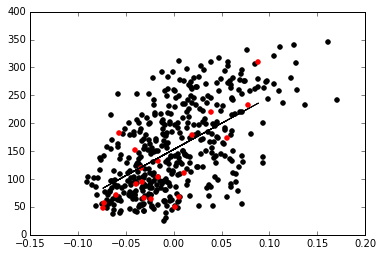

In [26]:
# Use the trained model to perform prediction
%matplotlib inline
plt.scatter(diabetes_X_train, diabetes_y_train,  color='black')
plt.scatter(diabetes_X_test, diabetes_y_test,  color='red')

plt.plot(diabetes_X_test, predictions, color='black')

## (Optional) Install OpenBLAS

# Example 5: Invoking a Keras model with SystemML

See [SystemML's deep learning documentation](http://apache.github.io/systemml/deep-learning) for more detail.

In [ ]:
from mlxtend.data import mnist_data
import numpy as np
from sklearn.utils import shuffle
# Download the MNIST dataset
X, y = mnist_data()
X, y = shuffle(X, y)
# Split the data into training and test
n_samples = len(X)
X_train = X[:int(.9 * n_samples)]
y_train = y[:int(.9 * n_samples)]
X_test = X[int(.9 * n_samples):]
y_test = y[int(.9 * n_samples):]
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout,Flatten
from keras import backend as K
from keras.models import Model
input_shape = (1,28,28) if K.image_data_format() == 'channels_first' else (28,28, 1)
keras_model = Sequential()
keras_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same'))
keras_model.add(MaxPooling2D(pool_size=(2, 2)))
keras_model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
keras_model.add(MaxPooling2D(pool_size=(2, 2)))
keras_model.add(Flatten())
keras_model.add(Dense(512, activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(10, activation='softmax'))

# Scale the input features
scale = 0.00390625
X_train = X_train*scale
X_test = X_test*scale

from systemml.mllearn import Keras2DML
sysml_model = Keras2DML(spark, keras_model, input_shape=(1,28,28), weights='weights_dir')
sysml_model.setConfigProperty('sysml.native.blas', 'openblas')
sysml_model.setConfigProperty('sysml.native.blas.directory', os.path.join(os.getcwd(),'OpenBLAS-0.2.20/'))
# sysml_model.setGPU(True).setForceGPU(True)
sysml_model.summary()
sysml_model.fit(X_train, y_train)

Using TensorFlow backend.


Loading the model from weights_dir...
SystemML Statistics:
Total execution time:		0.000 sec.
Number of executed Spark inst:	0.


[Stage 9:=======================================>                   (2 + 1) / 3]
+-------------------+---------------+--------------+------------+---------+--------------------+-------------------+--------------------+
|               Name|           Type|        Output|      Weight|     Bias|                 Top|             Bottom|Memory* (train/test)|
+-------------------+---------------+--------------+------------+---------+--------------------+-------------------+--------------------+
|     conv2d_1_input|           Data| (, 1, 28, 28)|            |         |conv2d_1_input,label|                   |                 1/0|
|           conv2d_1|    Convolution|(, 32, 28, 28)|   [32 X 25]| [32 X 1]|            conv2d_1|     conv2d_1_input|               25/13|
|conv2d_1_activation|           ReLU|(, 32, 28, 28)|            |         | conv2d_1_activation|    